# Pandas & SciPy for RecSys datasets

В данном jupyter notebook рассматриваются примеры использования библиотек pandas и scipy при работе с данным для построения рекомендательных систем.

* [Preprocessing](#preprocessing)
* [Pandas](#pandas)
    - [СategoryDType](#categorydtype)
    - [IntegerDType](#integerdtype)
    - [Sparse Type](#sparse-type)
* [SciPy.Sparse](#scipy)
    - [Matrix types](#matrix-types)
    - [Pandas to matrix](#pandas-to-matrix)
* [Links](#links)

In [1]:
import numpy as np 
import pandas as pd 
import scipy.sparse as sp
import os

In [16]:
for dirname, _, filenames in os.walk('data/'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

data/interactions.csv
data/items.csv
data/users.csv


<a id="preprocessing"></a>
# Preprocessing

Загрузим взаимодействия

In [27]:
df = pd.read_csv('data/interactions.csv')
df.head()

,user_id,item_id,progress,rating,start_date
0,126706,14433,80,NaN,2018-01-01
1,127290,140952,58,NaN,2018-01-01
2,66991,198453,89,NaN,2018-01-01
3,46791,83486,23,5.0,2018-01-01
4,79313,188770,88,5.0,2018-01-01


In [28]:
df['start_date'] = pd.to_datetime(df['start_date'])

In [29]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1533078 entries, 0 to 1533077
Data columns (total 5 columns):
 #   Column      Non-Null Count    Dtype         
---  ------      --------------    -----         
 0   user_id     1533078 non-null  int64         
 1   item_id     1533078 non-null  int64         
 2   progress    1533078 non-null  int64         
 3   rating      285356 non-null   float64       
 4   start_date  1533078 non-null  datetime64[ns]
dtypes: datetime64[ns](1), float64(1), int64(3)
memory usage: 58.5 MB


Проверим данные на дубликаты

In [30]:
duplicates = df.duplicated(subset=['user_id', 'item_id'], keep=False)
duplicates.sum()

160

In [31]:
df_duplicates = df[duplicates].sort_values(by=['user_id', 'start_date'])
df = df[~duplicates]

In [32]:
df_duplicates = df_duplicates.groupby(['user_id', 'item_id']).agg({
    'progress': 'max',
    'rating': 'max',
    'start_date': 'min'
})
df_duplicates.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 80 entries, (523, 49329) to (158041, 208145)
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   progress    80 non-null     int64         
 1   rating      35 non-null     float64       
 2   start_date  80 non-null     datetime64[ns]
dtypes: datetime64[ns](1), float64(1), int64(1)
memory usage: 3.4 KB


In [33]:
df = df.append(df_duplicates.reset_index(), ignore_index=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1532998 entries, 0 to 1532997
Data columns (total 5 columns):
 #   Column      Non-Null Count    Dtype         
---  ------      --------------    -----         
 0   user_id     1532998 non-null  int64         
 1   item_id     1532998 non-null  int64         
 2   progress    1532998 non-null  int64         
 3   rating      285355 non-null   float64       
 4   start_date  1532998 non-null  datetime64[ns]
dtypes: datetime64[ns](1), float64(1), int64(3)
memory usage: 58.5 MB


In [34]:
df.nunique()

user_id       151600
item_id        59599
progress         101
rating             5
start_date       730
dtype: int64

Как видно, у нас 1.5 миллиона строк, но уникальных значений гораздо меньше. 
Это свойство называется **низкой кардинальностью** и встречается во многих датасетах с "взаимодействиями". 

<a id="pandas"></a>
# Pandas


<a id="categorydtype"></a>
## CategoryDType

[CategoryDType](https://pandas.pydata.org/pandas-docs/stable/user_guide/categorical.html) - тип в pandas, который позволяет оптимизировать потребление памяти для строковых столбцов и задать логический порядок для значений в них.


In [35]:
df_cat = pd.DataFrame({'city': ['Moscow', 'London', 'Tokyo', 'Moscow']})
df_cat

,city
0,Moscow
1,London
2,Tokyo
3,Moscow


In [36]:
df_cat['city'] = df_cat['city'].astype('category')
df_cat

,city
0,Moscow
1,London
2,Tokyo
3,Moscow


In [37]:
df_cat['city_codes'] = df_cat['city'].cat.codes
df_cat

,city,city_codes
0,Moscow,1
1,London,0
2,Tokyo,2
3,Moscow,1


In [38]:
mapping = dict(enumerate(df_cat['city'].cat.categories))
mapping

{0: 'London', 1: 'Moscow', 2: 'Tokyo'}

Рассмотрим то, как такая конвертация типов может экономить память.

In [39]:
df_user_item = df[['user_id', 'item_id']].copy()

In [40]:
def num_bytes_format(num_bytes, float_prec=4):
    units = ['bytes', 'Kb', 'Mb', 'Gb', 'Tb', 'Pb', 'Eb']
    for unit in units[:-1]:
        if abs(num_bytes) < 1000:
            return f'{num_bytes:.{float_prec}f} {unit}'
        num_bytes /= 1000
    return f'{num_bytes:.4f} {units[-1]}'

In [41]:
num_bytes_ints = df_user_item.memory_usage(deep=True).sum()
num_bytes_format(num_bytes_ints)

'24.5281 Mb'

In [46]:
# Not working
# df_user_item = df_user_item.astype('string')
# num_bytes_str = df_user_item.memory_usage(deep=True).sum()
# num_bytes_format(num_bytes_str)

In [45]:
df_user_item = df_user_item.astype('category')
num_bytes_cat = df_user_item.memory_usage(deep=True).sum()
num_bytes_format(num_bytes_cat)

'21.8180 Mb'

In [48]:
# print(f'Экономия category относительно string: {(1 - num_bytes_cat / num_bytes_str) * 100:.2f}%')
print(f'Экономия ints относительно category: {(1 - num_bytes_ints / num_bytes_cat) * 100:.2f}%')

Экономия ints относительно category: -12.42%


In [49]:
df_user_item = df_user_item.astype(np.int64).astype('category')
num_bytes_int_cat = df_user_item.memory_usage(deep=True).sum()
num_bytes_format(num_bytes_int_cat)

'21.8180 Mb'

In [50]:
print(f'Экономия category on int64 относительно category on string: {(1 - num_bytes_int_cat / num_bytes_cat) * 100:.2f}%')

Экономия category on int64 относительно category on string: 0.00%


In [51]:
df_user_item['user_id'].cat.codes.dtype

dtype('int32')

<a id="integerdtype"></a>
## IntegerDType

[IntegerDType](https://pandas.pydata.org/pandas-docs/stable/user_guide/integer_na.html) - группа типов в pandas, который позволяет целочисленным столбцам содержать пропущенные значения. 

Для классического целочисленного типа есть свой "двойник". Отличаются только первыми заглавными буквами, например:
* numpy.int32 - pd.Int32DType
* numpy.uint32 - pd.UInt64DType


Этот тип стоит использовать только для экономии памяти при хранении датафрейма или при простых операциях на ним. Большинство библиотек этот тип в данный момент не поддерживают.

In [52]:
ratings = df['rating'].astype(np.float32).copy()

In [53]:
num_bytes_float = ratings.memory_usage(deep=True)
num_bytes_format(num_bytes_float)

'6.1321 Mb'

In [54]:
ratings = ratings.astype(pd.Int32Dtype())
num_bytes_Int32 = ratings.memory_usage(deep=True)
num_bytes_format(num_bytes_Int32)

'7.6651 Mb'

In [55]:
ratings = ratings.astype(pd.Int8Dtype())
num_bytes_Int8 = ratings.memory_usage(deep=True)
num_bytes_format(num_bytes_Int8)

'3.0661 Mb'

In [56]:
ratings

0          <NA>
1          <NA>
2          <NA>
3             5
4             5
           ... 
1532993    <NA>
1532994    <NA>
1532995       5
1532996       5
1532997       4
Name: rating, Length: 1532998, dtype: Int8

In [57]:
print(f'Экономия Int8DType относительно float64: {(1 - num_bytes_Int8 / num_bytes_float) * 100:.2f}%')

Экономия Int8DType относительно float64: 50.00%


<a id="sparse-type"></a>
## Sparse Type

[Sparse Type](https://pandas.pydata.org/pandas-docs/stable/user_guide/sparse.html) - тип данных в pandas для работы с разреженными данными.

Идея проста - храним только "известные" значения, остальное не храним и имитируем константой.

Сам тип создается на основе двух значений:
* dtype - тип сохраняемых значений
* fill_value - константа для пропущенных значений

In [58]:
sparse_type = pd.SparseDtype(np.float32, np.nan)
ratings = ratings.astype(np.float32).astype(sparse_type)

In [59]:
ratings

0          NaN
1          NaN
2          NaN
3          5.0
4          5.0
          ... 
1532993    NaN
1532994    NaN
1532995    5.0
1532996    5.0
1532997    4.0
Name: rating, Length: 1532998, dtype: Sparse[float32, nan]

In [60]:
num_bytes_sparse = ratings.memory_usage(deep=True)
num_bytes_format(num_bytes_sparse)

'2.2830 Mb'

In [61]:
print(f'Экономия sparse относительно Int8DType: {(1 - num_bytes_sparse / num_bytes_Int8) * 100:.2f}%')
print(f'Экономия sparse относительно float32: {(1 - num_bytes_sparse / num_bytes_float) * 100:.2f}%')

Экономия sparse относительно Int8DType: 25.54%
Экономия sparse относительно float32: 62.77%


In [62]:
ratings.sparse.density

0.18614179535785436

<a id="scipy"></a>
# SciPy.Sparse


<a id="matrix-types"></a>
## Matrix types

[Sparse matrix](https://docs.scipy.org/doc/scipy/reference/sparse.html) - разреженная матрица, которая хранит только известные значения.

Виды разреженных матриц в scipy.sparse:
* **coo_matrix** - A sparse matrix in COOrdinate format
* **csc_matrix** - Compressed Sparse Column matrix
* **csr_matrix** - Compressed Sparse Row matrix
* **bsr_matrix** - Block Sparse Row matrix
* **dia_matrix** - Sparse matrix with DIAgonal storage
* **dok_matrix** - Dictionary Of Keys based sparse matrix
* **lil_matrix** - Row-based list of lists sparse matrix

Их можно разделить на две группы:
* Классы для создания матриц
  * coo_matrix - тройки (строка, столбец, значение)
  * dok_matrix - словарь, где ключ - кортеж из строки и столбца, а значение - это значение :)
  * lil_matrix - список из списков, где внутренние списки - это строки
* Классы оптимизированные под оптимальное хранение и операции над матрицами
  * csr_matrix - сжатое построчное представление
  * csc_matrix - сжатое представление по столбцам
  * bsr_matrix - как csr_matrix, только хранятся "плотные блоки"
  * dia_matrix - диагональное представление
  
 
На практике чаще всего встречаются coo_matrix, csr_matrix и csc_matrix 

### coo_matrix



In [63]:
rows =   [1,  1, 0,  4,   2, 2]
cols =   [0,  1, 0,  5,   3, 3]
values = [-2, 7, 19, 1.0, 6, 8]

coo = sp.coo_matrix((values, (rows, cols)))
coo

<5x6 sparse matrix of type '<class 'numpy.float64'>'
	with 6 stored elements in COOrdinate format>

In [64]:
coo.todense()

matrix([[19.,  0.,  0.,  0.,  0.,  0.],
        [-2.,  7.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0., 14.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  1.]])

In [65]:
coo.row, coo.col, coo.data

(array([1, 1, 0, 4, 2, 2], dtype=int32),
 array([0, 1, 0, 5, 3, 3], dtype=int32),
 array([-2.,  7., 19.,  1.,  6.,  8.]))

### csr_matrix/csc_matrix

In [66]:
csr = coo.tocsr()
csr

<5x6 sparse matrix of type '<class 'numpy.float64'>'
	with 5 stored elements in Compressed Sparse Row format>

In [67]:
csr.todense()

matrix([[19.,  0.,  0.,  0.,  0.,  0.],
        [-2.,  7.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0., 14.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  1.]])

In [68]:
csr.indptr, csr.indices, csr.data

(array([0, 1, 3, 4, 4, 5], dtype=int32),
 array([0, 0, 1, 3, 5], dtype=int32),
 array([19., -2.,  7., 14.,  1.]))

* indptr - указатели, которые рассматриваются парами. Имеют два значения:
    * Индекс пары - номер строки 
    * Значения пары - начало и конец строки в data и indices
* indices - номер столбца
* data - значение

Как это работает:
* indptr -> (1, 3) -> 1-ая строка.
* 3 - 1 = 2 -> кол-во заполненных значений
* indices[1:3] = (0, 1) -> столбцы 2 значений
* data[1:3] = (-2, 7) -> сами значения
* -2 -> (1, 0)
* 7  -> (1, 1)



In [40]:
csc = coo.tocsc()
csc

<5x6 sparse matrix of type '<class 'numpy.float64'>'
	with 5 stored elements in Compressed Sparse Column format>

In [41]:
csc.todense()

matrix([[19.,  0.,  0.,  0.,  0.,  0.],
        [-2.,  7.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0., 14.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  1.]])

In [42]:
csc.indptr, csc.indices, csc.data

(array([0, 2, 3, 3, 4, 4, 5], dtype=int32),
 array([0, 1, 1, 2, 4], dtype=int32),
 array([19., -2.,  7., 14.,  1.]))

<a id="pandas-to-matrix"></a>
## Pandas to matrix

Для создания разреженной матрицы из dataframe с взаимодействиям нужно вначале определить соответствия между user/item ID и номерами строк/столбцов.

По сути, мы просто должны пронумеровать (начиная с 0) все уникальные ID.

In [43]:
df.head()

,user_id,item_id,progress,rating,start_date
0,126706,14433,80,NaN,2018-01-01
1,127290,140952,58,NaN,2018-01-01
2,66991,198453,89,NaN,2018-01-01
3,46791,83486,23,5.0,2018-01-01
4,79313,188770,88,5.0,2018-01-01


In [44]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1532998 entries, 0 to 1532997
Data columns (total 5 columns):
 #   Column      Non-Null Count    Dtype         
---  ------      --------------    -----         
 0   user_id     1532998 non-null  int64         
 1   item_id     1532998 non-null  int64         
 2   progress    1532998 non-null  int64         
 3   rating      285355 non-null   float64       
 4   start_date  1532998 non-null  datetime64[ns]
dtypes: datetime64[ns](1), float64(1), int64(3)
memory usage: 58.5 MB


In [45]:
df.nunique()

user_id       151600
item_id        59599
progress         101
rating             5
start_date       730
dtype: int64

* users_mapping - конвертация ID в номер строки
* users_inv_mapping - номер строки в ID

In [72]:
users_inv_mapping = dict(enumerate(df['user_id'].unique()))
users_mapping = {v: k for k, v in users_inv_mapping.items()}
len(users_mapping)

151600

In [47]:
users_mapping[126706], users_inv_mapping[0]

(0, 126706)

In [75]:
items_inv_mapping = dict(enumerate(df['item_id'].unique()))
items_mapping = {v: k for k, v in items_inv_mapping.items()}
len(items_mapping)

59599

In [76]:
items_mapping[14433], items_inv_mapping[0]

(0, 14433)

Имея данные отображения в виде словарей, мы теперь можем легко конвертировать наши столбцы user_id и item_id в массивы строк и столбцов и закинуть их в coo_matrix

In [77]:
rows = df['user_id'].map(users_mapping.get)
cols = df['item_id'].map(items_mapping.get)

rows.isna().sum(), cols.isna().sum()

(0, 0)

Заполняем единицей (аля implicit feedback)

In [78]:
coo = sp.coo_matrix((
    np.ones(df.shape[0], dtype=np.int8),
    (rows, cols)
))
coo

<151600x59599 sparse matrix of type '<class 'numpy.int8'>'
	with 1532998 stored elements in COOrdinate format>

In [79]:
num_bytes_format(coo.data.nbytes + coo.row.nbytes + coo.col.nbytes)

'13.7970 Mb'

Или значением из dataframe. Придумаем страшную формулу для взвешивания каждого взаимодействия на основе оценки и проценту прочитанного.

In [81]:
df['weight'] = ((df['progress'] + 1) / 101) * (2 ** df['rating'])
df['weight'] = df['weight'].astype(np.float32)

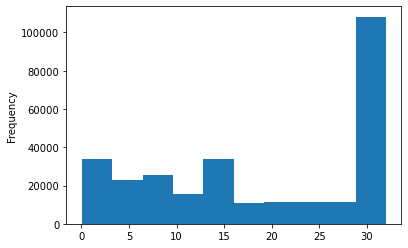

In [82]:
ax = df['weight'].plot.hist()

In [83]:
coo = sp.coo_matrix((
    df['weight'],
    (rows, cols)
))
coo

<151600x59599 sparse matrix of type '<class 'numpy.float32'>'
	with 1532998 stored elements in COOrdinate format>

In [84]:
num_bytes_format(coo.data.nbytes + coo.row.nbytes + coo.col.nbytes)

'18.3960 Mb'

<a id="links"></a>
# Links
* https://medium.com/@aakashgoel12/pandas-optimize-memory-and-speed-operation-17d8a66c8be4 - отличный гайд по эффективному использованию Pandas
* https://matteding.github.io/2019/04/25/sparse-matrices/ - шикарные визуализации разреженных матриц
* https://rushter.com/blog/scipy-sparse-matrices/ - еще один хороший разбор разреженных матриц